# DE Portoflio 4: Regression with Count Data

This model uses data about mass killings across states in the US from 2016 to 2021. The goal of the model is to predict number of killings given certain features considering the skewed and imbalanced data. The notebook analyzes the model that would best fit this goal.

Dataset Source: [https://data.world/associatedpress/mass-killings-public](https://data.world/associatedpress/mass-killings-public)

In [1]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler


### Load and Clean Data

##### Relevant Features
1. state: categorical value representing US states
2. num_offenders: numerical value representing the number of offenders involved in the incident
3. num_victims_killed: numerical value representing the number of victims killed
4. firstcod: categorical value representing the main cause of death or wounds
5. situation_type: categorical value describing the event 
6. location_type: categorical value describing where the event took place


In [2]:
df = pd.read_csv('mass_killing_incidents_public.csv')
df=df[['state', 'num_offenders', 'num_victims_killed', 'firstcod', 'situation_type', 'location_type']]
df=df.dropna()
display(df)

,state,num_offenders,num_victims_killed,firstcod,situation_type,location_type
0,WV,1,5,Smoke inhalation & burns,Arson,Residence/Other shelter
1,HI,1,4,Stabbing,Despondency,Residence/Other shelter
2,CA,3,4,Shooting,Gang conflict,Residence/Other shelter
3,MO,1,4,Smoke inhalation & burns,Arson,Residence/Other shelter
4,AL,1,4,Shooting,Undetermined,Commercial/Retail/Entertainment
...,...,...,...,...,...,...
581,MI,1,4,Shooting,Drug trade,Residence/Other shelter
582,NY,1,4,Smoke inhalation & burns,Arson,Residence/Other shelter
583,AZ,1,5,Shooting,Other,Residence/Other shelter
584,CA,1,7,Shooting,Employment grievance,Government/Transit


[5, 4, 4, 4, 4, 4, 5, 6, 4, 4, 4, 6, 4, 4, 18, 5, 5, 4, 4, 4, 4, 5, 4, 5, 4, 8, 5, 4, 5, 4, 4, 4, 4, 7, 6, 4, 7, 4, 5, 4, 4, 7, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 7, 4, 5, 4, 4, 21, 10, 4, 4, 4, 4, 6, 4, 5, 4, 6, 4, 5, 4, 4, 5, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 9, 4, 6, 4, 8, 6, 4, 4, 4, 10, 8, 4, 6, 5, 5, 4, 4, 4, 5, 4, 7, 4, 5, 4, 4, 4, 4, 4, 5, 7, 5, 5, 4, 4, 6, 4, 5, 4, 4, 4, 4, 4, 4, 5, 5, 4, 5, 4, 4, 4, 4, 4, 4, 5, 7, 4, 9, 23, 4, 4, 4, 5, 4, 5, 4, 4, 4, 5, 12, 4, 4, 7, 4, 5, 4, 4, 4, 5, 4, 5, 4, 4, 5, 4, 5, 4, 4, 4, 4, 12, 11, 4, 4, 5, 4, 4, 5, 5, 6, 10, 4, 4, 4, 6, 4, 4, 4, 17, 4, 4, 4, 4, 4, 5, 25, 8, 4, 4, 4, 60, 4, 8, 4, 4, 4, 5, 5, 5, 8, 7, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 5, 49, 5, 5, 8, 5, 4, 5, 5, 4, 4, 6, 4, 6, 5, 4, 14, 4, 6, 4, 4, 4, 9, 5, 4, 8, 4, 4, 5, 4, 5, 4, 5, 4, 9, 4, 4, 9, 4, 4, 4, 4, 7, 4, 5, 4, 4, 4, 6, 4, 4, 4, 4, 4, 6, 4, 7, 5, 4, 5, 4, 4, 4, 4, 6, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5

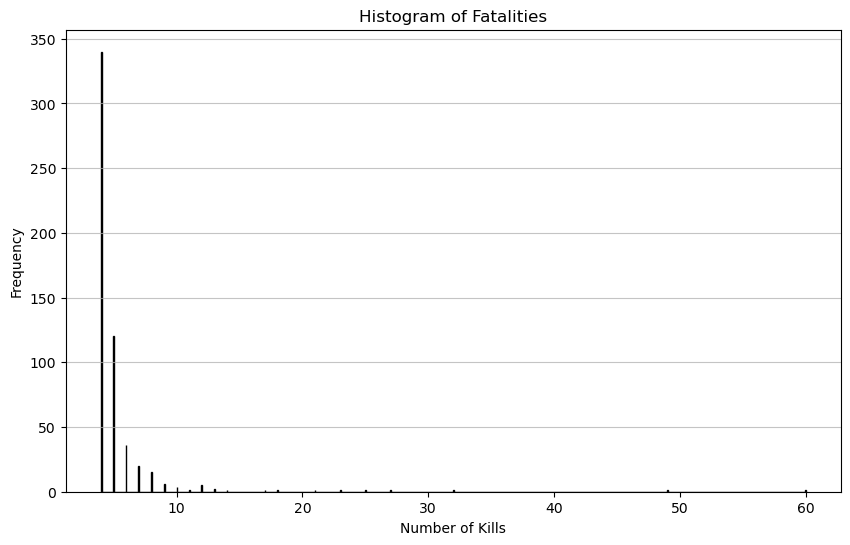

In [3]:
#Visualize number of kills 

print(df['num_victims_killed'].astype(int).to_list())

#Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['num_victims_killed'], bins=1000, color='skyblue', edgecolor='black')
plt.title('Histogram of Fatalities')
plt.xlabel('Number of Kills')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


The distribution is skewed and peaks around lower values (range 0 to 10). This means that the distribution is non-Gaussian and working on a different scale will aid at making predictions.

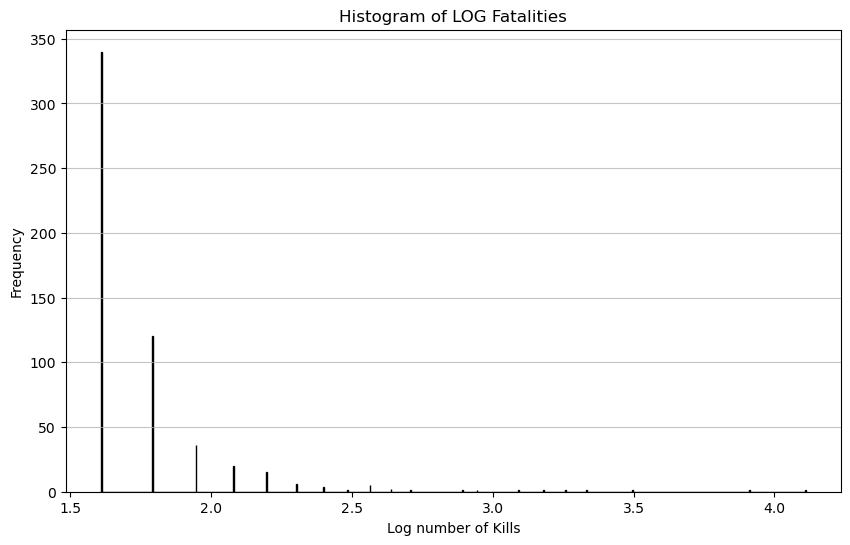

In [4]:
#Plot histograms of log values
plt.figure(figsize=(10, 6))
plt.hist(np.log(df['num_victims_killed']+1), bins=1000, color='skyblue', edgecolor='black')
plt.title('Histogram of LOG Fatalities')
plt.xlabel('Log number of Kills')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The distribution of log value is still non-gaussian, however it presents a more normal character than the first distribution of not transformed values.

### Prepare Data to Fit Models

In [5]:
#Define Y
Y = df['num_victims_killed']
Y_log = np.log(df['num_victims_killed']+1) #Take log out of Y to work on log scale

#Define X
X = df.drop(columns=['num_victims_killed']) #Drop outcome column

#Encode categorical X columns
X = pd.get_dummies(X, columns=['state', 'firstcod', 'situation_type', 'location_type'], drop_first=True).astype(int)



In [6]:
# Drop variables with 0 variability (no information) or high correlation (multicollinearity)

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X)
# Get the columns after variance thresholding
X_filtered = X.iloc[:, selector.get_support(indices=True)]

In [7]:
# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
correlation_matrix = X_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in drop and row not in drop:
            drop.append(column)
            break 

In [8]:
X_final = X_filtered.drop(columns=drop)

In [9]:
#Standardise features for better interpretation

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set 
scaler.fit(X_final)

#Transform to both the training set and the test set
X_train_scaled = pd.DataFrame(scaler.transform(X_final), columns=X_final.columns, index=X_final.index)

In [10]:
X_encoded_with_const = sm.add_constant(X_train_scaled)

### Fit Linear Regression Model with Y

In [11]:
#Fit model
model = sm.OLS(Y, X_encoded_with_const ).fit()

#Print results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     num_victims_killed   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     3.927
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           1.33e-20
Time:                        13:44:45   Log-Likelihood:                -1423.1
No. Observations:                 559   AIC:                             3004.
Df Residuals:                     480   BIC:                             3346.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

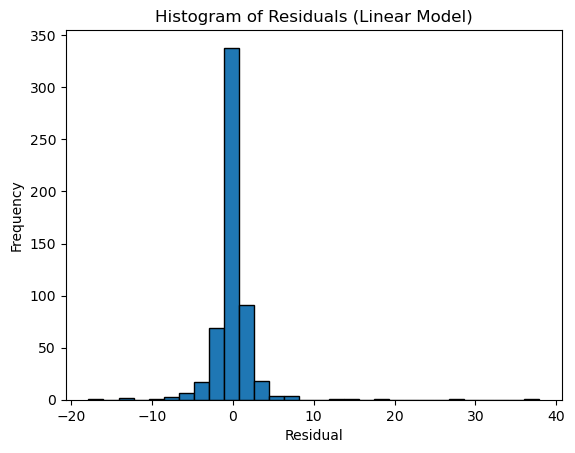

In [12]:
#Plot residuals
residuals = model.resid
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Linear Model)')
plt.show()

In [13]:
#Get regression coefficients and covariance
beta_mean = model.params
beta_cov = model.cov_params()

n_simulations=1000

#Simulate coefficients
sim_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

In [14]:
#Transform simulations into dataframe
sim_df = pd.DataFrame(sim_betas, columns=model.params.index)
column_names = sim_df.columns
print(column_names)

display(sim_df)

Index(['const', 'num_offenders', 'state_AL', 'state_AR', 'state_AZ',
       'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN',
       'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME',
       'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC',
       'state_ND', 'state_NE', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_SC', 'state_SD',
       'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA',
       'state_WI', 'state_WV', 'state_WY', 'firstcod_Blunt force',
       'firstcod_Drowning', 'firstcod_Pushing/Jumping', 'firstcod_Shooting',
       'firstcod_Smoke inhalation & burns', 'firstcod_Stabbing',
       'firstcod_Strangulation', 'firstcod_Vehicle crash',
       'situation_type_Despondency', 'situation_type_Drug trade',
       'situation_type_Employment grievance'

,const,num_offenders,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,...,situation_type_Terrorism,situation_type_Undetermined,location_type_Government/Transit,location_type_House of Worship,location_type_Medical facility,location_type_Multiple,location_type_Open space,location_type_Residence/Other shelter,location_type_School/College,location_type_Vehicle
0,5.332163,-0.235904,0.362338,0.056134,0.210125,0.272324,0.180132,0.319184,0.224052,0.117064,...,1.159727,-0.295474,-0.347683,0.307609,0.092370,-0.411365,-0.345683,-0.727870,0.619382,-0.380877
1,5.444709,-0.141569,0.435082,0.050255,0.509358,0.573034,0.293709,0.618723,0.266949,0.218018,...,1.321743,0.141554,-0.509699,0.393174,-0.148885,-0.501013,0.307826,0.067096,0.838491,-0.014659
2,5.484988,0.171704,-0.125840,-0.044654,0.183383,0.332177,0.300499,0.532053,-0.049603,0.000814,...,1.326418,0.137814,-0.129119,0.387331,0.111466,-0.071300,0.234078,0.393694,0.586583,0.125088
3,5.340251,0.124169,-0.011876,0.101363,-0.010059,-0.109382,0.118475,0.793579,-0.041126,0.081281,...,1.381574,0.010299,-0.030237,0.175941,0.105830,-0.113979,0.082859,0.174572,0.857287,-0.006050
4,5.329211,-0.063980,-0.227699,-0.304617,-0.273897,-0.580958,-0.115512,0.470818,0.117695,0.009871,...,1.171612,0.221590,-0.026685,0.162542,0.162725,-0.414383,0.126198,0.062211,0.494751,-0.106297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.238466,-0.053566,-0.244983,0.020937,-0.023477,-0.305493,-0.071169,0.480133,-0.054042,0.104102,...,1.260822,-0.004644,0.001247,0.371370,0.184197,-0.324277,0.202620,0.441563,0.711918,0.117207
996,5.226391,-0.073037,-0.104086,-0.309267,-0.329374,-0.491985,-0.200439,0.537371,0.085305,-0.231336,...,1.360659,0.016290,0.087727,0.119913,0.195585,-0.035750,-0.020440,0.358157,0.650016,0.150990
997,5.302938,-0.088405,0.288501,-0.024388,0.532530,0.628981,0.077735,0.820538,0.408505,0.222897,...,1.277345,-0.619119,-0.090632,0.369921,0.212830,-0.122515,0.067297,-0.049835,0.696265,0.054135
998,5.297400,0.123343,0.615594,0.190173,0.631968,0.830377,0.494552,0.582422,0.147077,0.361778,...,1.611235,0.553698,-0.182742,0.398508,0.033254,-0.589553,0.002159,-0.031994,0.589429,0.174234


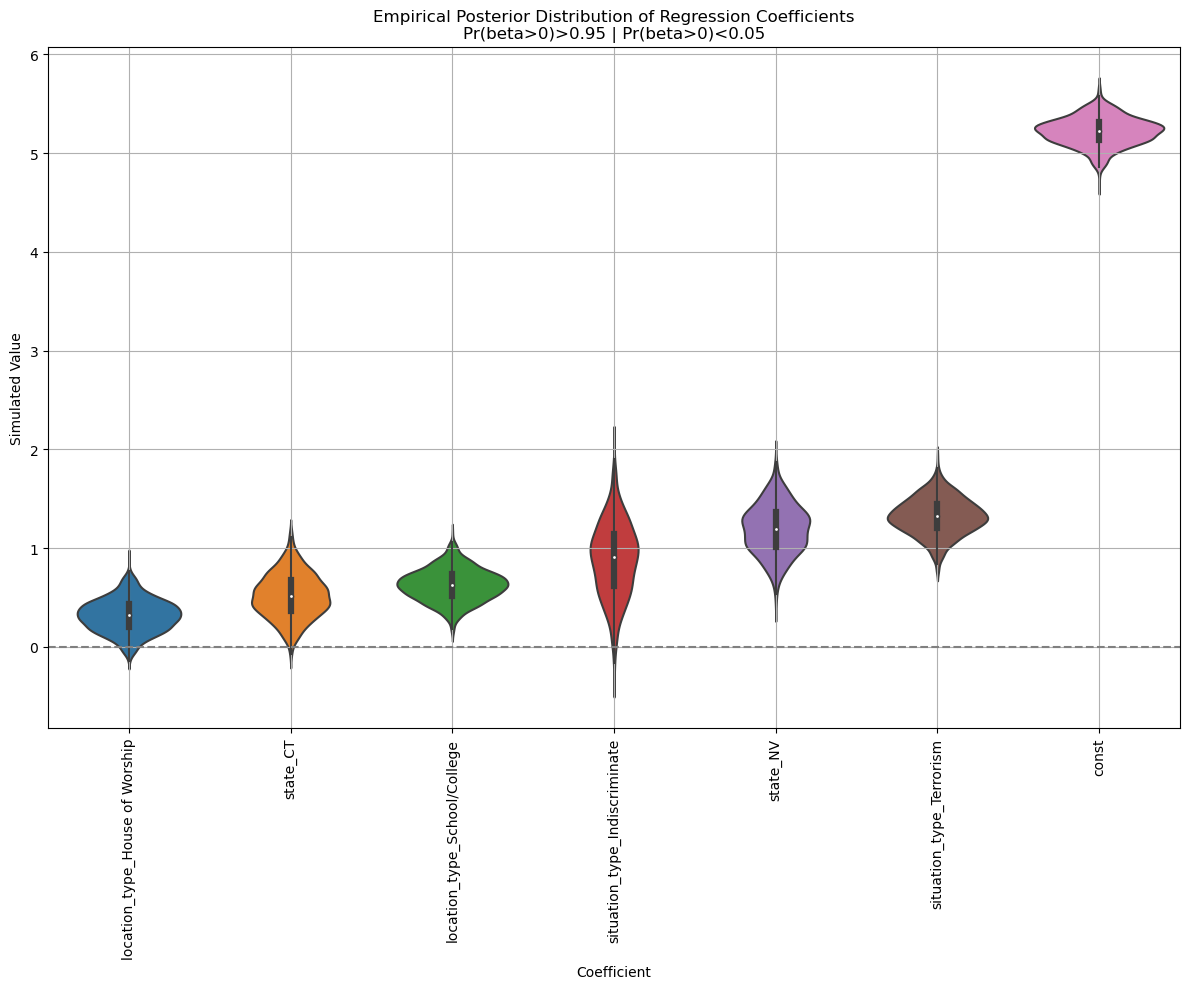

In [15]:
#Convert the DataFrame to long format
long_df = sim_df.melt(var_name='Coefficient', value_name='Value')

#Calculate probability of coef > 0 
prob_greater = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

#Filter coefficients based on probability threshold
filtered_coefs = prob_greater[
    (prob_greater['P(coef>0)'] > 0.95) | (prob_greater['P(coef>0)'] < 0.05)
]['Coefficient']

#Include only selected coefficients
filtered_long = long_df[long_df['Coefficient'].isin(filtered_coefs)]

#Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long.groupby('Coefficient')['Value'].median().reset_index()

#Sort medians
medians_sorted = medians.sort_values(by='Value')

#Plotting coefficients
plt.figure(figsize=(12, 10))
sns.violinplot(x='Coefficient', y='Value', data=filtered_long, order=medians_sorted['Coefficient'])

#Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

#Display plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [16]:
#Store predictions in array
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [17]:
#Generate predictions for simulations
for i in range(n_simulations):
    beta_simulation = sim_betas[i]
    predicted_rate = np.dot(X_encoded_with_const, beta_simulation)
    predicted_counts[i] = np.random.normal(predicted_rate,np.sqrt(model.scale))

##### Evaluate Linear Regression Model

In [18]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


#Caluclate evaluation metrics
correlation = np.corrcoef(monte_carlo_medians, Y)[0, 1]
rmse = np.sqrt(mean_squared_error(Y, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - Y)  # Mean prediction error
coverage = np.mean((Y >= prediction_intervals[0,:]) & (Y <= prediction_intervals[1,:]))

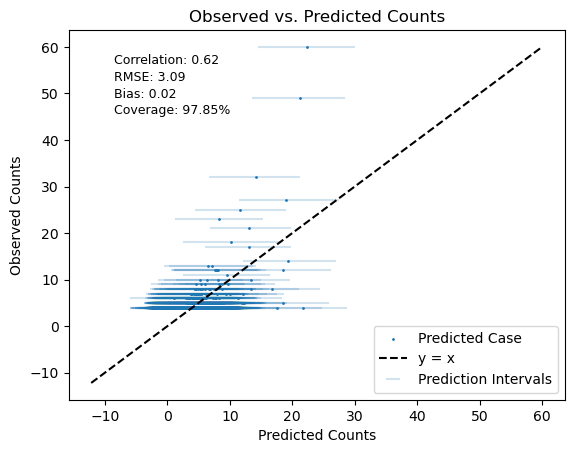

In [19]:


#Make predictions 1D
predicted_counts_flat = predicted_counts.flatten()

#Concatenate predictions with y in an array
combined_array = np.concatenate([predicted_counts_flat, Y])

#Get min and max of predictions and Y array
min_val = combined_array.min()
max_val = combined_array.max()

#Plot predictions
scatter = plt.scatter(monte_carlo_medians, Y, s=1, alpha=1, label='Predicted Case')
errorbar = plt.errorbar(monte_carlo_medians, Y, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

#Metric legend
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

#Plot legend
plt.legend(loc='lower right')


text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Counts')
plt.xlabel('Predicted Counts')
plt.ylabel('Observed Counts')
plt.show()


### Fit Linear Regression Model with Y log

In [20]:
#Fit linear model with Y log
model = sm.OLS(Y_log, X_encoded_with_const ).fit()

#Plot results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     num_victims_killed   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     4.510
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           4.01e-25
Time:                        13:44:47   Log-Likelihood:                 46.996
No. Observations:                 559   AIC:                             64.01
Df Residuals:                     480   BIC:                             405.8
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

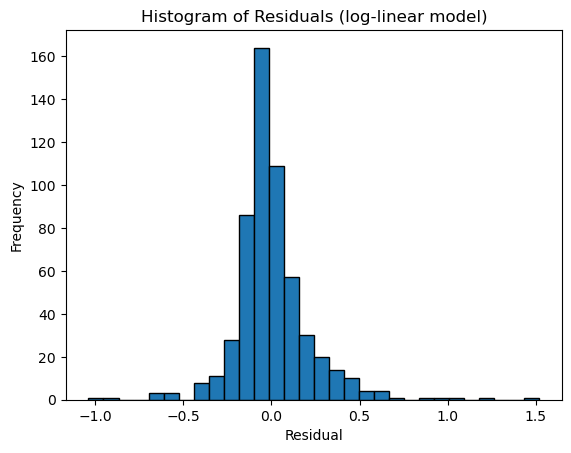

In [21]:
#Plot residuals
residuals = model.resid
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (log-linear model)')
plt.show()

In [22]:
#Extract beta coefficients and covariance
beta_mean = model.params
beta_cov = model.cov_params()

#Define number of simulations we want to generate
n_simulations = 1000

#Simulate coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

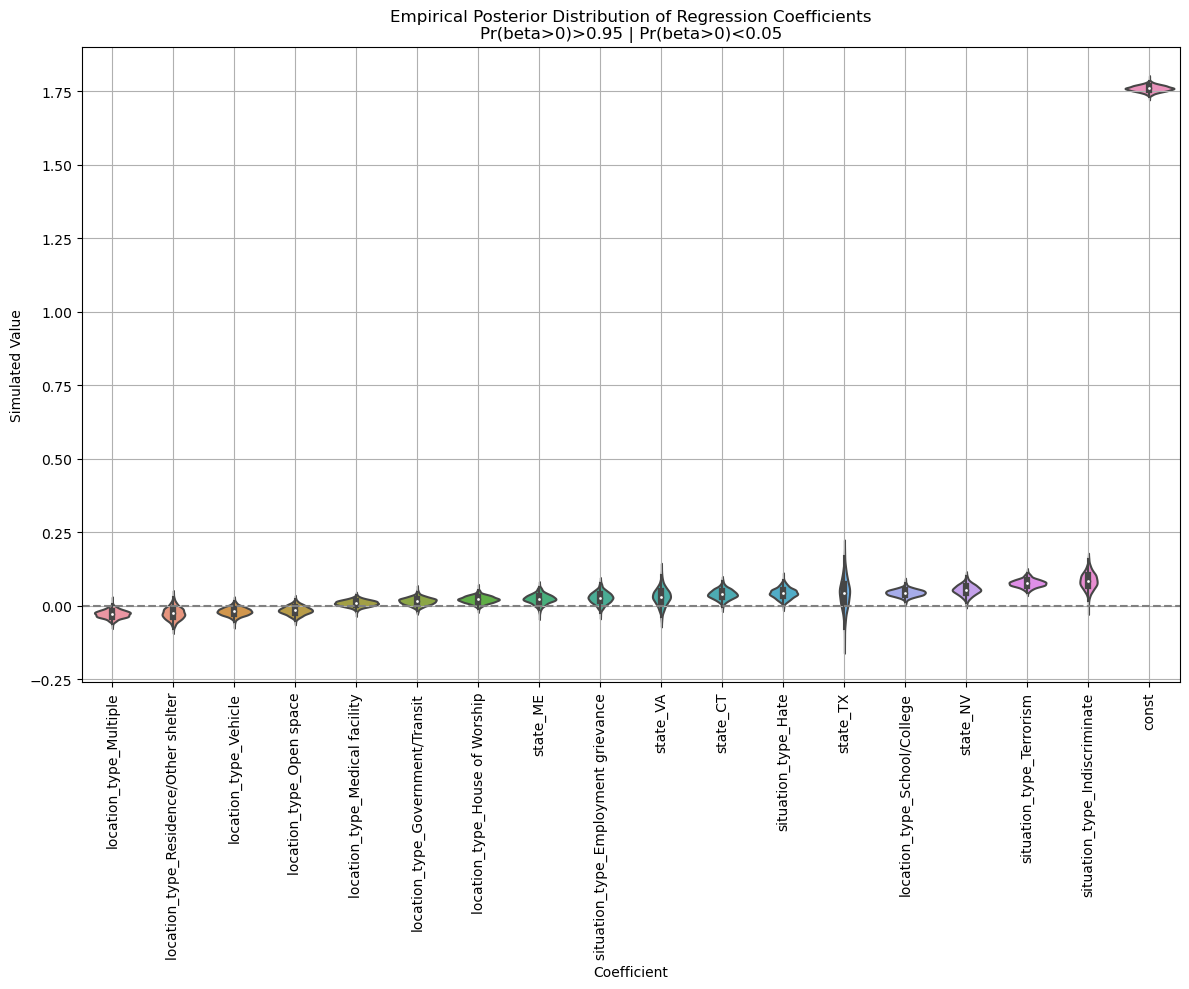

In [23]:
#Transform simulations into a DataFrame 
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

#Convert DataFrame to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

#Calculate the probability of coef to above 0
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

#Filter coefficients based on the probability threshold
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.80) | (prob_greater_than_zero['P(coef>0)'] < 0.20)
]['Coefficient']

#Filter the dataframe to have only selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

#Calculate the median and sort them
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()
medians_sorted = medians.sort_values(by='Value')


#Plot coefficients
plt.figure(figsize=(12, 10))
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

#Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')


plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [24]:
#Store predictions in an array
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [25]:
#Generate predictions
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_log_rate = np.dot(X_encoded_with_const, beta_simulation)
    predicted_counts[i] = np.exp(np.random.normal(predicted_log_rate,np.sqrt(model.scale)))

#### Evaluate Linear Regression Model

In [26]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)

#Calculate evaluation metrics for model
correlation = np.corrcoef(monte_carlo_medians, Y)[0, 1]
rmse = np.sqrt(mean_squared_error(Y, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - Y)  # Mean prediction error
coverage = np.mean((Y >= prediction_intervals[0,:]) & (Y <= prediction_intervals[1,:]))

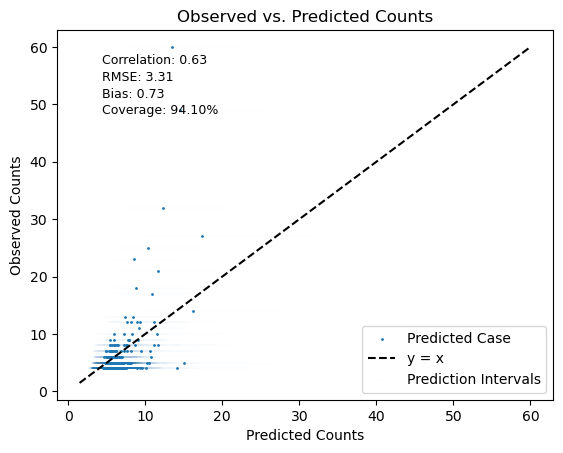

In [27]:
#Make predictions 1D
predicted_counts_flat = predicted_counts.flatten()

#Concatenate predictions with y
combined_array = np.concatenate([predicted_counts_flat, Y])

#Calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plot
scatter = plt.scatter(monte_carlo_medians, Y, s=1, alpha=1, label='Predicted Case')
errorbar = plt.errorbar(monte_carlo_medians, Y, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.01, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

#Metric legend
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

#Plot legend
plt.legend(loc='lower right')

#Annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Counts')
plt.xlabel('Predicted Counts')
plt.ylabel('Observed Counts')
plt.show()


### Fit Poisson Regression Model with Y

In [28]:
from statsmodels.api import GLM, Poisson

In [29]:
#Fit Poisson Regression
model = sm.GLM(Y, X_encoded_with_const, family=sm.families.Poisson()).fit()

#Print results
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     num_victims_killed   No. Observations:                  559
Model:                            GLM   Df Residuals:                      480
Model Family:                 Poisson   Df Model:                           78
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1127.5
Date:                Mon, 01 Apr 2024   Deviance:                       333.37
Time:                        13:44:48   Pearson chi2:                     351.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5567
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [30]:
#Extract beta coefficients
beta_mean = model.params
beta_cov = model.cov_params()

#define number of simulations we want to generate 
n_simulations = 1000

#Simulate coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

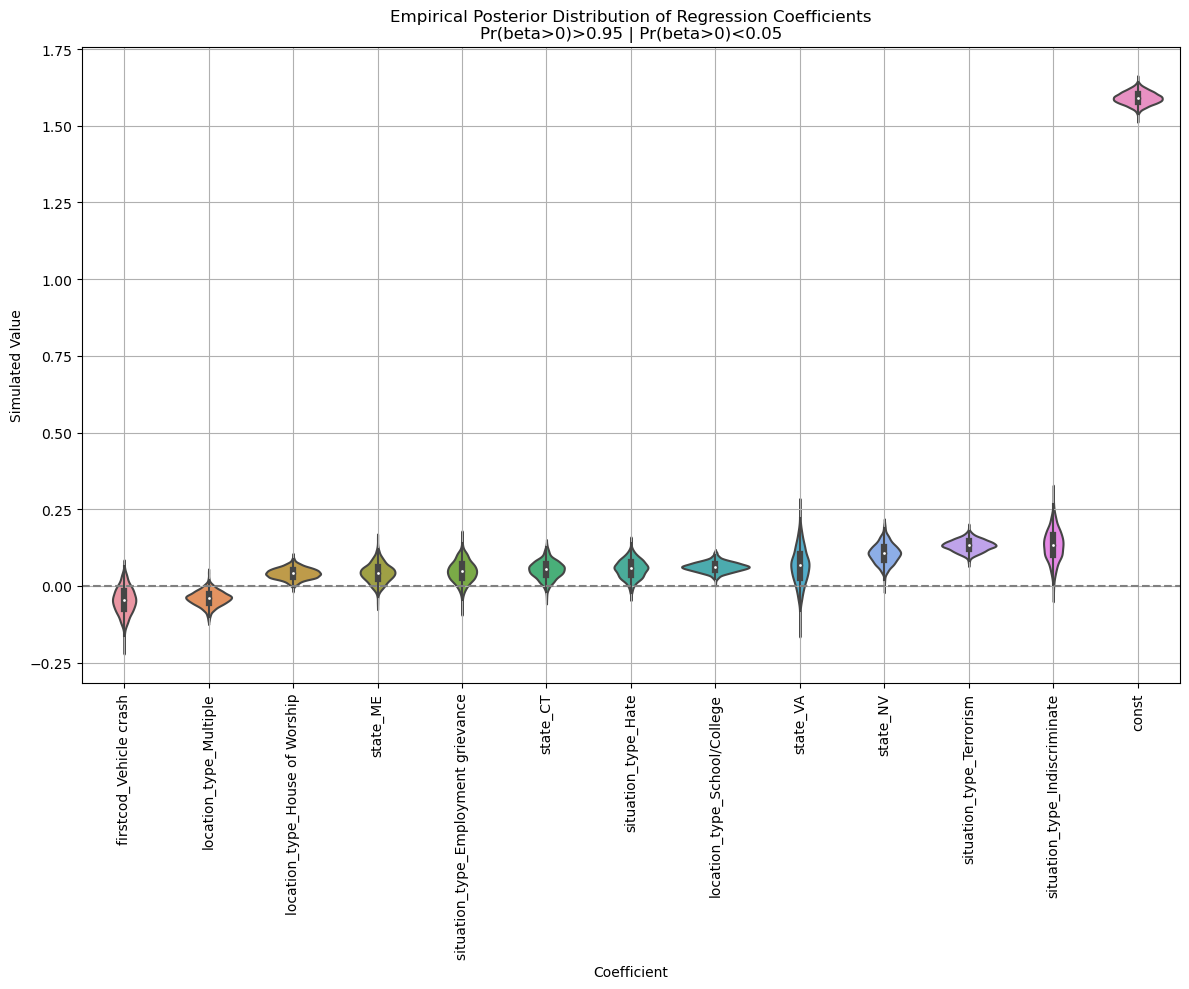

In [31]:
#Transform simulated coefficients into a DataFrame
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

#Convert the DataFrame to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

#Calculate the probability of coef to be above 0
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

#Filter coefficients and sleect inly those that met the criertia
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.80) | (prob_greater_than_zero['P(coef>0)'] < 0.20)
]['Coefficient']

#Filter the dataframe to have only selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

#Calculate the median and sort them
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()
medians_sorted = medians.sort_values(by='Value')


#Plot coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

#Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')


plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

#Show plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [32]:
#Store predictions in array
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [33]:
#Generate predictions
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.exp(np.dot(X_encoded_with_const, beta_simulation))
    predicted_counts[i] = np.random.poisson(predicted_rate)

#### Evaluate Poisson Regression Model

In [34]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


#Calculate evaluation metrics
correlation = np.corrcoef(monte_carlo_medians, Y)[0, 1]
rmse = np.sqrt(mean_squared_error(Y, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - Y)  # Mean prediction error
coverage = np.mean((Y >= prediction_intervals[0,:]) & (Y <= prediction_intervals[1,:]))

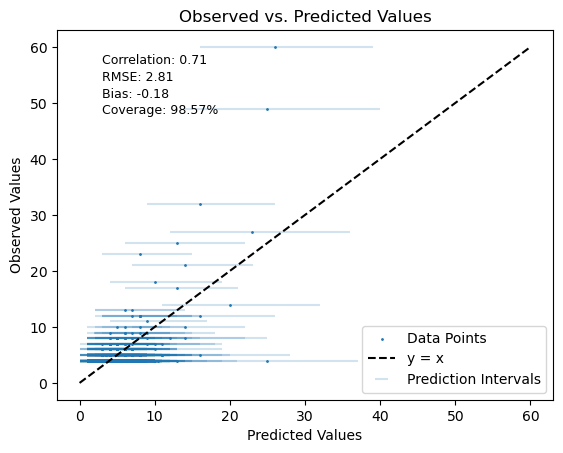

In [35]:
#Make predictions 1D
predicted_counts_flat = predicted_counts.flatten()

#Concatenate the predictions with y
combined_array = np.concatenate([predicted_counts_flat, Y])

#calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plot
scatter = plt.scatter(monte_carlo_medians, Y, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, Y, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

#Metric legend
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

#Plot legend
plt.legend(loc='lower right')

# ext annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()


#### Analysis
Analyzing and comparing the performance of all 3 models, the Poisson regression model is the better choice as it has the lowest RMSE, and in increased correlation and coverage. This suggests that the Poisson model is more likely to accurately predict the number of victims killed based on a dataset follwoing a non-Gaussian distribution.